# 3. Example: ETK DA using Reservoir Computing ML Model

So far, our "forecast model" has been the same model used to generate the nature run data. In practical application, this isn't possible. In this example, we'll complicate things by training and using a Reservoir Computing Machine Learning Model. RC models are a type of relatively simple Neural Network that tend to perform very well in DA tasks.

This directory contains a self-contained RCModel module, rc.py.

In [1]:
import dabench as dab
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

## A. Create Nature Run

We'll create a nature run just like before, but since we're going to train the RC model we'll need to split the data into training and test datasets (with a transient dataset between the two to spinup the RC model). DataAssimBench has an easy way to split the nature run.



In [2]:
train_size = 100000
transient_size = 500
test_size = 2000

In [3]:
nature_run = dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True)

In [4]:
nature_run.generate(n_steps=(train_size + transient_size + test_size))

In [5]:
# Split into train/transient/test
nr_train, nr_transient, nr_test = nature_run.split_train_valid_test(train_size, transient_size, test_size)

## B. Generate observations: Only on test set

In [6]:
# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, 2000, 5), # Observation every 5th timestep
    random_location_count = 3, # We'll select 3 variables of the 6D l96 system for random sampling
    stationary_observers=True, # The same variables will be used for at each observation timestep
    error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
    error_sd = 0.5, # Standard deviation for observation error, Gaussian/Normal distribution
    random_seed=91, # We can specify a random seed. Default is 99
    store_as_jax=True
)

# Making observations
obs_vec_l96 = obs_l96.observe()

## C. Define AND train model

Now, unlike before, we also have to train our model. We'll use some methods built into the RCModel class.

In [7]:
forecast_model = dab.model.RCModel(system_dim=6, 
                reservoir_dim=1600, 
                input_dim=6, 
                sparse_adj_matrix=False, 
                sparsity=0.99,
                readout_method='linear',
                sigma=0.07,
                spectral_radius = 0.1, 
                leak_rate=0.7,
                log_beta=-18.41)

In [8]:
# # Train: Takes ~5 minutes
# forecast_model.weights_init()
# forecast_model.train(nr_train)
# forecast_model.save_weights('./l96_rc_weights_6d.pkl')

In [9]:
# Shortcut: load the W_out weights from previous training
weights_path = './l96_rc_weights_6d.pkl'
forecast_model.weights_init()
forecast_model.load_weights(weights_path)

Predict Forward to see how our model does without DA

In [10]:
forecast_model.generate(nr_test.values, save_states=True)  
out_obj = forecast_model.predict(nr_test, delta_t = 0.01, n_steps = 1000, initial_index=1000, spinup_steps=1000)

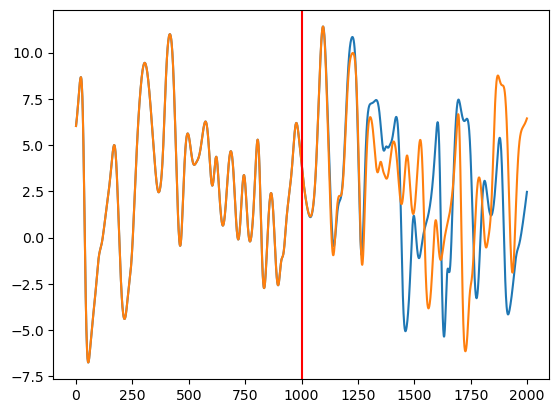

In [11]:
plt.plot(nr_test.values[:, 0])
plt.plot(out_obj.values[:, 0])
plt.axvline(1000, color='red')

Wrap as dab.model.Model object. In this case, we'll be running the model in the "reservoir dimension" of the RC model (1600,). We can easily map to the system dimension using the readout() method when needed.

## D. Set up and run DA Cycler

Next we setup and run the DA Cycler.

### I. Observation Operator

In [12]:
S = jnp.zeros((6, 6))
S = S.at[jnp.arange(S.shape[0]), np.tile(obs_vec_l96.location_indices[0], 2)
             ].set(1)
H = S @ forecast_model.Wout.T

### II. Define DA Cycler

In [13]:
dc = dab.dacycler.ETKF(system_dim=forecast_model.reservoir_dim,
                   delta_t=nature_run.delta_t,
                   H=H,
                   model_obj=forecast_model, # Forecast model we created above
                   ensemble_dim=10 # Ensemble dim for Ensemble Kalman Filter
                  )


### III.  Generate perturbed initial conditions

In [14]:
ics = jnp.stack([
    forecast_model.generate(
        nr_transient.values
        + np.random.normal(size = (nr_transient.time_dim, nr_transient.system_dim), scale=3.0))[-1]
    for i in range(10)])

### IV. Run DA Cycler

In [15]:
analysis_window = 0.1
start_time = nr_test.times[0]
delta_t = 0.01

In [16]:
%%time

# Needs to be at least 1 otherwise unequal number of obs per cycle
cur_tstep = 1

# ETKF input state is an ensemble with error
etkf_x0 = dab.vector.StateVector(
    values=ics,
    store_as_jax=True)

out_statevec = dc.cycle(
    input_state = etkf_x0,
    start_time = nr_test.times[cur_tstep],
    obs_vector = obs_vec_l96,
    obs_error_sd = 1.0,
    analysis_window=0.1, 
    timesteps=995)

CPU times: user 23.7 s, sys: 158 ms, total: 23.8 s
Wall time: 23.8 s


### V. Plot Results

In [ ]:
# Transform to system space:
out_statevals = np.zeros((out_statevec.time_dim, out_statevec.values.shape[1], 6))
for i in range(out_statevec.values.shape[0]):
    for j in range(out_statevec.values.shape[1]):
        out_statevals[i, j] = forecast_model.readout(jnp.array(out_statevec.values[i,j]))

In [ ]:
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(out_statevec.times, nr_test.values[1:996,j], lw = 3, label = 'True')
    ax.errorbar(out_statevec.times, np.mean(out_statevals, axis=1)[:,j],
                yerr=np.ptp(out_statevals, axis=1)[:,j], elinewidth=0.5, ecolor='red')
    if j in obs_vec_l96.location_indices[0]:
        ax.plot(obs_vec_l96.times[:200], obs_vec_l96.values[:200, np.where(j == obs_vec_l96.location_indices[0])[0]])
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
ax.set_xlabel('Time (s)')
plt.show()